<a href="https://colab.research.google.com/github/FleaBusyBeeBergs/dtsa5511-cnn-cancer-detection/blob/main/cnn-cancer-detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cancer detection using CNN

## Introduction

In [1]:
from google.colab import files
from collections import Counter
import os
import shutil
import zipfile
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.optimizers import RMSprop, SGD
from keras.utils import to_categorical


In [2]:
# get set up with kaggle
files.upload()
!pip install -q kaggle
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# note to self: '_kaggle' file is located in dtsa5511 folder

Saving kaggle.json to kaggle.json


In [3]:
# get data from kaggle
!kaggle competitions download -c histopathologic-cancer-detection > /dev/null
!unzip histopathologic-cancer-detection.zip -d ./data > /dev/null

100% 6.31G/6.31G [00:34<00:00, 197MB/s]


### The Problem

Briefly describe the challenge problem and NLP.

The purpose of this project is to participate in the (now closed) Kaggle competition [Histopathologic Cancer Detection](https://www.kaggle.com/competitions/histopathologic-cancer-detection) by creating an algorithm to classify metastatic cancer cells in small images taken from larger digital pathology scans. The Kaggle site describes this data as
" a slightly modified version of the [PatchCamelyon (PCam) benchmark dataset](https://github.com/basveeling/pcam) (the original PCam dataset contains duplicate images due to its probabilistic sampling, however, the version presented on Kaggle does not contain duplicates)."

Identification of cancerous cells by a human is time consuming and expensive. Using ML models as a tool to assist a human in flagging positive classes can reduce the amount of time it would take for a patient to receive treatment, and care providers can focus more of their time on more complicated cases rather than screening out large numbers of negative classes.

### The Data

Describe the size, dimension, structure, etc., of the data.

In [4]:
file_path = './data/train_labels.csv'
df = pd.read_csv(file_path)
df.head(3)

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


## EDA

Show a few visualizations like histograms. Describe any data cleaning procedures. Based on your EDA, what is your plan of analysis?

In [6]:
null_count = df.isnull().sum()
null_count

,0
id,0
label,0


No cleaning is necessary, but this is a very large dataset. I'll work with a subset when creating a model.


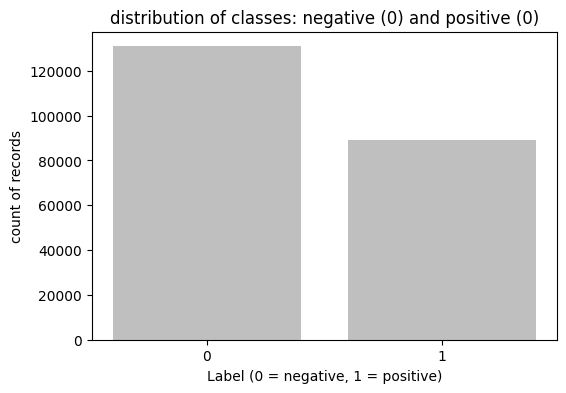

In [7]:
# plot dist
labels, counts = zip(*Counter(df['label']).items())
plt.figure(figsize = (6, 4))
plt.bar(labels, counts, color=['grey', 'grey'], alpha = 0.5)
plt.xlabel('Label (0 = negative, 1 = positive)')
plt.ylabel('count of records')
plt.title('distribution of classes: negative (0) and positive (0)')
plt.xticks(labels)
plt.show()

Classes are imbalanced, which could introduce bias in our model. I'll take a balanced sampple.

In [8]:
# ref 1.
# sample a balance of classes
df_neg = df[df['label'] == 0].sample(n = 10000, random_state = 5511)
df_pos = df[df['label'] == 1].sample(n = 10000, random_state = 5511)
df_sample = pd.concat([df_neg, df_pos])
df_sample.info()

<class 'pandas.core.frame.DataFrame'>
Index: 20000 entries, 102923 to 22962
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      20000 non-null  object
 1   label   20000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.8+ KB


In [9]:
# add column for image file path
df_sample['path'] = df_sample['id'].apply(lambda x: os.path.join('./data/train', str(x) + '.tif'))
df_sample.head(3)

,id,label,path
102923,c49aa322df7d43eedf267bbd31292c6fb9974418,0,./data/train/c49aa322df7d43eedf267bbd31292c6fb...
81742,e0b86d66a79ee5fa0c1bdfef8f4fcc414244b63c,0,./data/train/e0b86d66a79ee5fa0c1bdfef8f4fcc414...
124044,7f2dfc21777d22d881f97f7ed29d6350c7bd25f1,0,./data/train/7f2dfc21777d22d881f97f7ed29d6350c...


Lets have a look at what these images look like:

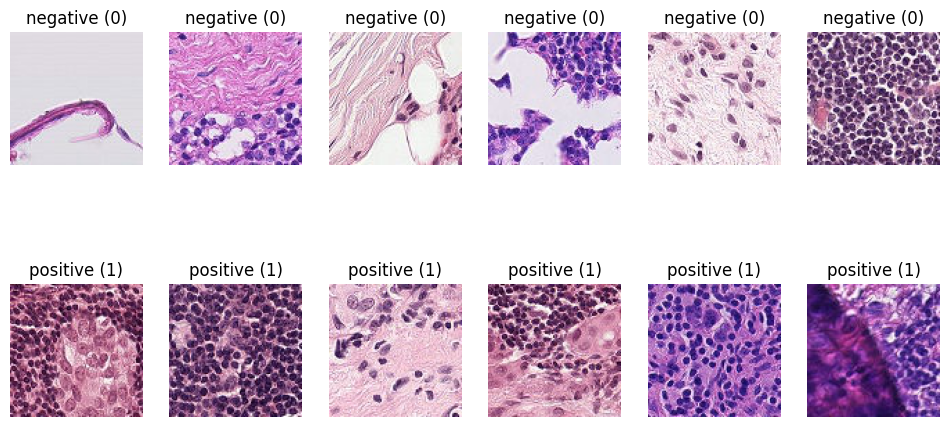

In [ ]:
# enter number img to disp from each class
num_images = 6

plt.figure(figsize = (12, 6))

# plot classes
for i in range(num_images):
    # neg
    image_neg = plt.imread(df_sample[df_sample['label'] == 0]['path'].iloc[i])
    plt.subplot(2, 6, i + 1)
    plt.imshow(image_neg)
    plt.axis('off')
    plt.title('negative (0)')

    # pos
    image_pos = plt.imread(df_sample[df_sample['label'] == 1]['path'].iloc[i])
    plt.subplot(2, 6, 6 + i + 1)
    plt.imshow(image_pos)
    plt.axis('off')
    plt.title('positive (1)')

plt.show()

In [ ]:
unique_dimensions = set()
random_indices = np.random.randint(0, len(df_sample), 1000)
for index in random_indices:
    image = io.imread(df_sample["path"].iloc[index])
    image_height, image_width, image_channels = image.shape
    unique_dimensions.add((image_height, image_width, image_channels))

print(f"Unique dimension: {unique_dimensions}")
print(f"Image Height: {image_height} pixels")
print(f"Image Width: {image_width} pixels")
print(f"Number of Channels (Depth): {image_channels}")

Unique dimension: {(96, 96, 3)}
Image Height: 96 pixels
Image Width: 96 pixels
Number of Channels (Depth): 3


In [10]:
# load and standardize images
X = np.array([plt.imread(path) for path in df_sample['path']])  # Load images
X = X / 255.0  # Normalize pixel values

In [11]:
# labels encoded
y = df_sample['label'].values
y = to_categorical(y)

In [12]:
# train and val sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=5511)

In [ ]:
model1 = Sequential()
pool_size = (2, 2)
filter_size = (3, 3)

# first block: [conv-maxpool]2
model1.add(Conv2D(32, # number of filters
                  filter_size,
                  activation = 'relu',
                  input_shape = (96, 96, 3))) # pixels, channels

model1.add(MaxPooling2D(pool_size = pool_size))


# second block
model1.add(Conv2D(64,
                  filter_size,
                  activation = 'relu'))

model1.add(MaxPooling2D(pool_size = pool_size))

# Fully connected layers
model1.add(Flatten())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.5))
model1.add(Dense(2, activation='softmax'))  # Output layer for binary classification

Notes on [Conv-MaxPool]2 structure:


*   min val loss: 0.4337
*   max val accuracy: 0.8183
*   6 epochs
*   time to run using v2-8 TPU is about 41 min

In [ ]:
model2 = Sequential()
pool_size = (2, 2)
filter_size = (3, 3)

# first block [conv-conv-maxpool]
model2.add(Conv2D(32, filter_size, activation='relu', input_shape=(96, 96, 3)))
model2.add(Conv2D(32, filter_size, activation='relu'))
model2.add(MaxPooling2D(pool_size=pool_size))

# 2nd block [conv-conv-maxpool]
model2.add(Conv2D(64, filter_size, activation='relu'))
model2.add(Conv2D(64, filter_size, activation='relu'))
model2.add(MaxPooling2D(pool_size=pool_size))

# fully connected layers
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(2, activation='softmax'))


In [13]:
model3 = Sequential()
pool_size = (2, 2)
filter_size = (3, 3)

# first block [conv-conv-conv-maxpool]
model3.add(Conv2D(32, filter_size, activation='relu', input_shape=(96, 96, 3)))
model3.add(Conv2D(32, filter_size, activation='relu'))
model3.add(Conv2D(32, filter_size, activation='relu'))
model3.add(MaxPooling2D(pool_size=pool_size))

# 2nd block [conv-conv-maxpool]
model3.add(Conv2D(64, filter_size, activation='relu'))
model3.add(Conv2D(64, filter_size, activation='relu'))
model3.add(Conv2D(32, filter_size, activation='relu'))
model3.add(MaxPooling2D(pool_size=pool_size))

# fully connected layers
model3.add(Flatten())
model3.add(Dense(128, activation='relu'))
model3.add(Dropout(0.5))
model3.add(Dense(2, activation='softmax'))

In [30]:
model5 = Sequential()
pool_size = (2, 2)
filter_size = (3, 3)

# first block: [conv-maxpool]2
model5.add(Conv2D(32, # number of filters
                  filter_size,
                  activation = 'relu',
                  input_shape = (96, 96, 3))) # pixels, channels

model5.add(MaxPooling2D(pool_size = pool_size))


# second block
model5.add(Conv2D(64,
                  filter_size,
                  activation = 'relu'))

model5.add(MaxPooling2D(pool_size = pool_size))

# 3rd block
model5.add(Conv2D(64,
                  filter_size,
                  activation = 'relu'))

model5.add(MaxPooling2D(pool_size = pool_size))

# Fully connected layers
model5.add(Flatten())
model5.add(Dense(128, activation='relu'))
model5.add(Dropout(0.5))
model5.add(Dense(2, activation='sigmoid'))

In [31]:
# Compile the model
model5.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])


In [32]:
# Train the model
history = model5.fit(X_train, y_train,
                    validation_data=(X_val, y_val),
                    epochs=6,
                    batch_size=32)

Epoch 1/6
500/500 [==============================] - 189s 375ms/step - loss: 0.5282 - accuracy: 0.7481 - val_loss: 0.4753 - val_accuracy: 0.7812
Epoch 2/6
500/500 [==============================] - 186s 373ms/step - loss: 0.4853 - accuracy: 0.7807 - val_loss: 0.4443 - val_accuracy: 0.7983
Epoch 3/6
500/500 [==============================] - 186s 372ms/step - loss: 0.4673 - accuracy: 0.7884 - val_loss: 0.4422 - val_accuracy: 0.8012
Epoch 4/6
500/500 [==============================] - 185s 370ms/step - loss: 0.4488 - accuracy: 0.7983 - val_loss: 0.4096 - val_accuracy: 0.8227
Epoch 5/6
500/500 [==============================] - 184s 368ms/step - loss: 0.4262 - accuracy: 0.8104 - val_loss: 0.4305 - val_accuracy: 0.8105
Epoch 6/6
500/500 [==============================] - 183s 367ms/step - loss: 0.4076 - accuracy: 0.8201 - val_loss: 0.3834 - val_accuracy: 0.8360


In [33]:
histroy_df = pd.DataFrame(history.history)
histroy_df

,loss,accuracy,val_loss,val_accuracy
0,0.528157,0.748062,0.475289,0.78125
1,0.485259,0.780688,0.444253,0.79825
2,0.467261,0.788437,0.442235,0.80125
3,0.448831,0.798250,0.409641,0.82275
4,0.426163,0.810375,0.430453,0.81050
5,0.407593,0.820063,0.383384,0.83600


## Architecture

Describe your model architecture and reasoning for why you believe that specific architecture would be suitable for this problem. Compare multiple architectures and tune hyperparameters.

## Results and Analysis

### Kaggle competition ranking

Submission file .csv format:

id,label
0b2ea2a822ad23fdb1b5dd26653da899fbd2c0d5,0
95596b92e5066c5c52466c90b69ff089b39f2737,0
248e6738860e2ebcf6258cdc1f32f299e0c76914,0
etc.

## Conclusion

Discuss and interpret results as well as learnings and takeaways. What did and did not help improve the performance of your models? What improvements could you try in the future?

## References

1. [This Kaggle notebook](https://www.kaggle.com/code/arcotgautham/msds-histopathologic-cancer-detection-cnn-model) for guidance on getting the data from Kaggle and getting a smaller sample of it.